In [1]:
#Objects
class gas_generator:
    def __init__(self):
        #generator attribs
        self._performance = 0 #%
        self._gas_lv = 100.0 #%
        self._state = False #
        self._outputs = 0
    
    def turn_on(self, perf):
        self.state = True
        self.performance = perf
    
    def turn_off(self):
        self.state = False
        self.performance = 0

    @property
    def performance(self):
        return self._performance
    
    @property
    def gas_lv(self):
        return self._gas_lv

    @property
    def is_start(self):
        return self._is_start
    
    @property
    def state(self):
        return self._state
    
    @property
    def outputs(self):
        return (self.performance / 100) * (1067.0) #per time step

    @property
    def burning_output(self):
        return 0.8378 * (self._performance / 100) #per time step

    @performance.setter
    def performance(self, perf):
        assert 60 <= perf <= 100 or perf == 0, ("Valid performance is 0 and 60-100")
        if not (self._gas_lv < 80.0):
            self._performance = perf
            self.state = True
        else:
            self._performance = 0
            self.state = False

    @gas_lv.setter
    def gas_lv(self, lv):
        assert 0 < lv <= 100 and isinstance(lv, float), "value must be float in range 0.1-100"
        if self._gas_lv < 100.0:
            self._gas_lv = lv
        else:
            self._gas_lv = 100.0
    
    @state.setter
    def state(self, s):
        assert isinstance(s, bool), "state must either be True/False"
        if s == False:
            self._performance = 0
        self._state = s


# #TEST--------------------------------------------------------------------------
# t = gas_generator()
# t.state = True
# # t.gas_lv = 100.0
# t.performance = 100
# # t.is_start
# # t.is_start = False
# # t.outputs,t.performance
# # t.performance = 100
# # t.outputs

# # t.gas_lv = 10.0
# # t.gas_lv, t.outputs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



processed_df = pd.read_csv('egat_data_2022_8_26_to_2023_01_18.csv')
timestamp_dt = pd.to_datetime(processed_df['timestamp'])
processed_df['timestamp'] = timestamp_dt
processed_df = processed_df.set_index('timestamp')
#remove package loss 
con = processed_df[processed_df.kw_gen < 0]
processed_df = processed_df.drop(con.index)

#00:00 - 00:30
con1 = processed_df[(processed_df.index.hour == 0) & (processed_df.index.minute < 30)]
#22:00 - 23:59
con2 = processed_df[(processed_df.index.hour >= 22) & (processed_df.index.hour <= 23)]

filtered_df = processed_df.drop(con1.index)
filtered_df = filtered_df.drop(con2.index)
filtered_df = filtered_df[(filtered_df.index.day == 7) & (filtered_df.index.month == 10)]

filtered_df['real_demand'] = filtered_df.kw_demand + filtered_df.kw_gen
filtered_df['real_demand'] = filtered_df['real_demand']
filtered_df['kw_demand'] = filtered_df['kw_demand']
filtered_df

,kw_demand,kw_gen,gas_lv,kw_solar,real_demand
timestamp,,,,,
2022-10-07 00:30:07,3773.47,1065.44,20.29,-0.11,4838.91
2022-10-07 00:31:12,3773.47,1064.62,20.28,-0.10,4838.09
2022-10-07 00:32:16,3768.38,1065.77,18.79,-0.10,4834.15
2022-10-07 00:33:21,2306.03,1065.77,18.62,-0.09,3371.80
2022-10-07 00:34:26,2828.72,1065.07,18.63,-0.09,3893.79
...,...,...,...,...,...
2022-10-07 21:55:33,139.55,0.00,33.78,-0.13,139.55
2022-10-07 21:56:37,154.69,0.00,33.85,-0.13,154.69
2022-10-07 21:57:42,533.41,0.00,33.79,-0.13,533.41


In [3]:
#Environment
import gym
import numpy as np
from gym.spaces import Box, Dict, Discrete, MultiBinary, Space
from collections import deque

class egat_env(gym.Env): #window 30 slide 30
    def __init__(self, ref_data):
        #state/action definitions
        self.win_size = 30
        self.generator1 = gas_generator()
        self.action_space = Discrete(3) #stay, off, on
        self.observation_space = Box(0, 1, shape=(self.win_size, ), dtype = np.float64)
        self.gt_data = ref_data
        self.threshold = 0.5854354047619048 #brutally calculated :D
        self.scaled_factor = 7000
        
    def reset(self):
        self.ramping = 0
        self.prev_action = 0 #tracking of state of previous timestep
        self.generator1.state = False
        #fill buffer
        self.current_obs = deque(np.array([], dtype=np.float64), maxlen = self.win_size)
        self.len_data = len(self.gt_data)
        for i in range(self.win_size):
            self.current_obs.append(self.gt_data.real_demand[-self.len_data] / self.scaled_factor)
            self.len_data -= 1
        
        self.num_refill = 4 #number of refill per day

        return np.array(self.current_obs, dtype=np.float64).reshape(self.win_size,)
        
            
    def step(self, action):
        reward = -1
        info = {}
        done = False

        if self.len_data == 0:
            done = True
            reward = 1000
        else:
            self.current_obs.append(self.gt_data.real_demand[-self.len_data] / self.scaled_factor)
            self.len_data -= 1
            if self.prev_action == 0 and action == 0: #from ST to ST
                if 1 <= self.ramping <= 15:
                    self.ramping += 1
                elif self.ramping > 15: #fully turn onm start reducing
                    if self.generator1.gas_lv > 15:
                        self.current_obs[-1] = self.current_obs[-1] - (self.generator1.outputs / self.scaled_factor) #reduce kw
                        self.generator1.gas_lv -= self.generator1.burning_output #burn
                        m = np.array(self.current_obs).mean() #cal new mean
                        reward = (self.threshold - m) * 10
                    else:
                        if self.num_refill > 0:
                            reward = -500
                            self.num_refill -= 1
                            self.generator1.gas_lv = 100
                        else:
                            reward = -5000
                            done = True
                else:
                    pass #generator off, donothing
            elif (self.prev_action == 1 and action == 0) or (self.prev_action == 0 and action == 1):#from OFF to ST or ST to OFF
                self.generator1.state = False
                self.generator1.performance = 0
            elif (self.prev_action == 2 and action == 0) or (self.prev_action == 0 and action == 2):#from ON to ST or ST to ON
                self.generator1.state = True
                self.ramping = 1
            else:
                reward = -100
                done = True

        self.prev_action = action
        return np.array(self.current_obs, dtype=np.float64).reshape(self.win_size,), reward, done, info 


from stable_baselines3.common.env_checker import check_env

env = egat_env(filtered_df)
s = env.reset()
check_env(env)
done = False
while not done:
    action = np.random.randint(0,6)
    next_state, reward, done, info = env.step(action)
    print(action, reward, info)


# next_state, reward, done, info = env.step(0)
# next_state, reward, done, info = env.step(1)
# next_state, reward, done, info = env.step(1)
# print(reward, done, info, env.prev_action)

# next_state, reward, done, info = env.step(0)
# next_state, reward, done, info = env.step(2)
# next_state, reward, done, info = env.step(0)
# next_state, reward, done, info = env.step(2)
# print(reward, done, info)

# next_state, reward, done, info = env.step(2)
# next_state, reward, done, info = env.step(0)
# print(reward, done, info)

# next_state, reward, done, info = env.step(1)
# next_state, reward, done, info = env.step(0)
# print(reward, done, info)


# next_state, reward, done, info = env.step(1)
# next_state, reward, done, info = env.step(2)
# print(reward, done, info)


/home/mmm/miniconda3/envs/egat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5 -100 {}


In [5]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True


In [209]:
log_dir = "tmp/"
x, y = ts2xy(load_results(log_dir), "timesteps")
load_results(log_dir)

,index,r,l,t
0,0,-101.000000,2,0.004457
1,1,-103.000000,4,0.006589
2,2,-102.000000,3,0.007874
3,3,-104.000000,5,0.009954
4,4,-101.000000,2,0.010715
...,...,...,...,...
1632,1632,-1167.000000,1167,51.918891
1633,1633,-1167.000000,1167,52.755571
1634,1634,-1167.000000,1167,53.093455
1635,1635,238.044566,1167,53.948580


# train dqn

In [6]:
# Create log dir
from stable_baselines3 import PPO, DQN
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = egat_env(filtered_df)
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
timesteps = 5e6

model = PPO('MlpPolicy', env, verbose = 0)
model.learn(total_timesteps = timesteps, callback=callback)

/home/mmm/miniconda3/envs/egat/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -103.09
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -103.09 - Last mean reward per episode: -102.80
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: -102.80 - Last mean reward per episode: -104.56
Num timesteps: 4000
Best mean reward: -102.80 - Last mean reward per episode: -104.10
Num timesteps: 5000
Best mean reward: -102.80 - Last mean reward per episode: -106.59
Num timesteps: 6000
Best mean reward: -102.80 - Last mean reward per episode: -107.76
Num timesteps: 7000
Best mean reward: -102.80 - Last mean reward per episode: -109.76
Num timesteps: 8000
Best mean reward: -102.80 - Last mean reward per episode: -112.67
Num timesteps: 9000
Best mean reward: -102.80 - Last mean reward per episode: -116.10
Num timesteps: 10000
Best mean reward: -102.80 - Last mean reward per episode: -119.09
Num timesteps: 11000
Best mean reward: -102.80 - Last mean rew

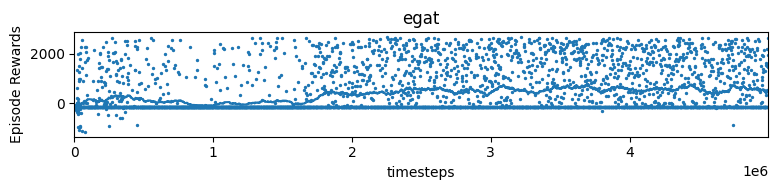

In [7]:
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "egat")
plt.show()

In [40]:
from collections import deque

t = filtered_df.copy()
current_obs = deque(np.array([], dtype=np.float64), maxlen = 10)
len_data = len(t)
for i in range(10):
    current_obs.append(t.real_demand[-len_data])
    len_data -= 1

print(t.head(10))
print(current_obs, type(current_obs))
print(np.array(current_obs, dtype=np.float64))

from statistics import mean
mean(current_obs)

                     kw_demand   kw_gen  gas_lv  kw_solar  real_demand
timestamp                                                             
2022-10-07 00:30:07    3773.47  1065.44   20.29     -0.11      4838.91
2022-10-07 00:31:12    3773.47  1064.62   20.28     -0.10      4838.09
2022-10-07 00:32:16    3768.38  1065.77   18.79     -0.10      4834.15
2022-10-07 00:33:21    2306.03  1065.77   18.62     -0.09      3371.80
2022-10-07 00:34:26    2828.72  1065.07   18.63     -0.09      3893.79
2022-10-07 00:35:31    1870.53  1065.59   17.17     -0.09      2936.12
2022-10-07 00:36:36    1930.75  1065.80   17.13     -0.08      2996.55
2022-10-07 00:37:40    1930.77  1066.14   17.05     -0.08      2996.91
2022-10-07 00:38:45    2659.74  1063.61   17.02     -0.08      3723.35
2022-10-07 00:39:50    2738.56  1065.04   15.65     -0.07      3803.60
deque([4838.91, 4838.09, 4834.15, 3371.8, 3893.79, 2936.12, 2996.55, 2996.91, 3723.3499999999995, 3803.5999999999995], maxlen=10) <class 'collection

3823.3269999999998